### the plan:
1. set up a small sample with 3 classes, 2400 training and 600 testing
2. check we can load/print svgs
3. check keras datagen works with trivial classifier
4. try larger convnet?
    - are larger filters worthwhile?
5. try vgg16 batchnorm insertion trick?

In [123]:
import os
import h5py

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import keras
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers
from keras import backend as K
import glob
import shutil

%matplotlib inline

### download data

In [28]:
!wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip

--2017-04-10 19:23:32--  http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip
Resolving cybertron.cg.tu-berlin.de... 130.149.80.52
Connecting to cybertron.cg.tu-berlin.de|130.149.80.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550098987 (525M) [application/zip]
Saving to: ‘sketches_png.zip.1’

sketches_png.zip.1  100%[===================>] 524.62M   348KB/s    in 24m 30s 

2017-04-10 19:48:02 (365 KB/s) - ‘sketches_png.zip.1’ saved [550098987/550098987]



In [29]:
!unzip sketches_png.zip

Archive:  sketches_png.zip
   creating: png/
   creating: png/airplane/
  inflating: png/airplane/1.png      
  inflating: png/airplane/10.png     
  inflating: png/airplane/11.png     
  inflating: png/airplane/12.png     
  inflating: png/airplane/13.png     
  inflating: png/airplane/14.png     
  inflating: png/airplane/15.png     
  inflating: png/airplane/16.png     
  inflating: png/airplane/17.png     
  inflating: png/airplane/18.png     
  inflating: png/airplane/19.png     
  inflating: png/airplane/2.png      
  inflating: png/airplane/20.png     
  inflating: png/airplane/21.png     
  inflating: png/airplane/22.png     
  inflating: png/airplane/23.png     
  inflating: png/airplane/24.png     
  inflating: png/airplane/25.png     
  inflating: png/airplane/26.png     
  inflating: png/airplane/27.png     
  inflating: png/airplane/28.png     
  inflating: png/airplane/29.png     
  inflating: png/airplane/3.png      
  inflating: png/airplane/30.png     
  inflating: png

In [31]:
%mkdir data
%mv png tu_berlin
%mv tu_berlin data/tu-berlin
%mkdir data/tu-berlin/train
%mv data/tu-berlin/* data/tu-berlin/train

mkdir: data/tu-berlin/train: File exists
mv: rename data/tu-berlin/train to data/tu-berlin/train/train: Invalid argument


### sample data

In [32]:
sample_classes = ['tiger','tent','toilet']
train_size = 60
test_size = 20

%rm -r ./data/tu-berlin/sample/train/*
%rm -r ./data/tu-berlin/sample/test/*
%mkdir -p ./data/tu-berlin/sample/train/
%mkdir -p ./data/tu-berlin/sample/test/


for sample_class in sample_classes:
    %mkdir ./data/tu-berlin/sample/train/{sample_class} 
    %mkdir ./data/tu-berlin/sample/test/{sample_class}
    # get current class
    pts = glob.glob('./data/tu-berlin/train/'+sample_class+'/*')
    print sample_class, len(pts)
    for i in range(train_size):
        shutil.copyfile(pts[i], './data/tu-berlin/sample/train/'\
              +sample_class+'/'+os.path.basename(pts[i]))
    for i in range(train_size, train_size+test_size):
        shutil.copyfile(pts[i], './data/tu-berlin/sample/test/'\
              +sample_class+'/'+os.path.basename(pts[i]))


rm: ./data/tu-berlin/sample/train/*: No such file or directory
rm: ./data/tu-berlin/sample/test/*: No such file or directory
tiger 80
tent 80
toilet 80


In [104]:
data_root = 'data/tu-berlin/sample/'
train_data_dir = data_root + 'train'
validation_data_dir = data_root + 'test'

img_width = None
img_height = None
channels = None
num_classes = None

In [100]:
def show_sample(X, y, prediction=-1):
    im = X
    cmap = None
    if (im.shape[2] == 1):
        im = np.squeeze(im, (2,))
        cmap = 'gray'
    plt.imshow(im, interpolation='none', cmap = cmap)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (str(y), str(prediction)))
    else:
        plt.title("Class = %s" % (str(y)))

    plt.axis('on')
    plt.show()
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    cmap = None
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] == 1):
            ims = np.squeeze(ims, (3,))
            cmap = 'gray'
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none', cmap=cmap)

In [119]:
batch_size = 10

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
#         target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

batch, y = train_generator.next()
img_height = batch.shape[1]
img_width = batch.shape[2]
channels = batch.shape[3]
num_classes = len(y[0])
print img_height, img_width, channels, num_classes

Found 180 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
256 256 1 3


(32, 256, 256, 1) (32, 3)


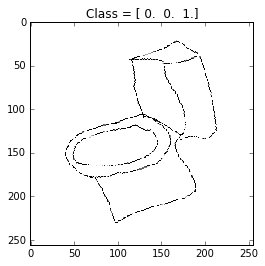

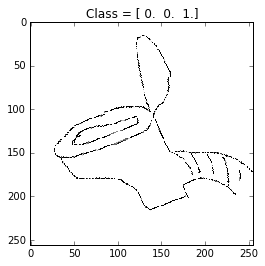

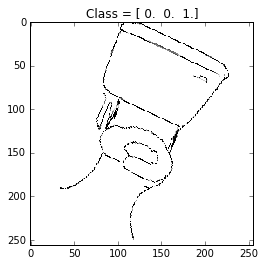

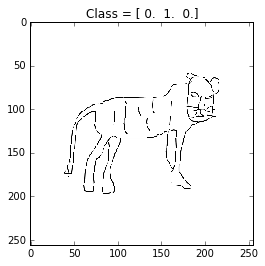

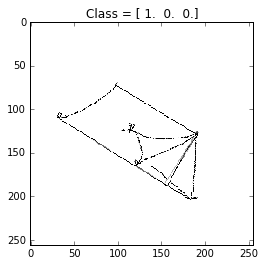

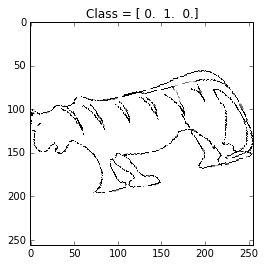

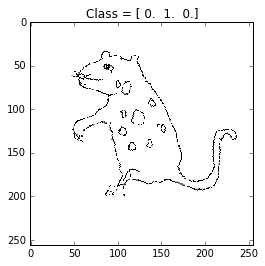

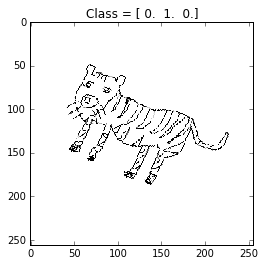

In [102]:
for X_batch, Y_batch in train_generator:
    print X_batch.shape, Y_batch.shape
#     plots(X_batch[:12,:,:,:], figsize=(12,12), rows=3)
    for i in range(len(Y_batch)):
        show_sample(X_batch[i, :, :, :], Y_batch[i])
        if i > 6:
            break
    break

In [117]:
model_name = 'sketchnet1'
%mkdir -p logs/{model_name}
%mkdir -p models/{model_name}

tensorboard_callback =\
    TensorBoard(log_dir='./logs/'+model_name+'/', 
                histogram_freq=0, 
                write_graph=False, write_images=False)
checkpoint_callback =\
    ModelCheckpoint('./models/'+model_name+'.h5', 
                    monitor='val_acc', verbose=0, 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode='auto', period=1)

In [125]:
# now try training a simple convnet
model = Sequential()
model.add(Convolution2D(64, (3, 3), 
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_height, channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3), 
                        padding='same', 
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))

model.add(Convolution2D(256, (3, 3), 
                        padding='same', 
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# initialize optimizer
opt = rmsprop(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [126]:
nb_epoch = 1

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 6,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 2,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
#         initial_epoch = 0,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)

Epoch 1/1
6/6 [==============================] - 65s - loss: 3.7019 - acc: 0.3167 - val_loss: 1.2071 - val_acc: 0.3000


In [127]:
# set higher learning rate and train for more epochs:
K.set_value(opt.lr, 0.01)

nb_epoch = 1

hist = model.fit_generator(
        train_generator,
        steps_per_epoch = 6,
        nb_epoch = nb_epoch,
        validation_data = validation_generator,
        validation_steps = 2,
#         nb_val_samples = nb_validation_samples,
        verbose = 1,
#         initial_epoch = 0,
        callbacks=[tensorboard_callback, 
                   checkpoint_callback]
)

Epoch 1/1
6/6 [==============================] - 61s - loss: 8.8832 - acc: 0.3667 - val_loss: 11.2827 - val_acc: 0.3000
